### SIMA
SIMA is a fully featured toolbox including motion correction and cell detection. Here we illustrate how one can integrate FISSA into their workflow.

For more information about the toolbox see: http://www.losonczylab.org/sima/1.3.2/

Imports

In [1]:
# SIMA
import sima
import sima.segment

# Plotting toolbox
import holoviews as hv
%load_ext holoviews.ipython

# file operations
import glob

# FISSA
import fissa.core as fissa

/home/swk/.virtualenvs/main/local/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


Setup data

In [2]:
# Define folder where tiffs are present
folder = '../exampleData/20150529_mini/'

# Find tiffs in folder
tiffs  = sorted(glob.glob(folder+'/*.tif'))

# define SIMA dataset
sequences = [sima.Sequence.create('TIFF', tiff) for tiff in tiffs[:1]]
try:
    dataset = sima.ImagingDataset(sequences, 'example.sima')
except:
    dataset = sima.ImagingDataset.load('example.sima')


Detect cells with sima

In [3]:
stica_approach = sima.segment.STICA(components=3)
stica_approach.append(sima.segment.SparseROIsFromMasks())
stica_approach.append(sima.segment.SmoothROIBoundaries())
stica_approach.append(sima.segment.MergeOverlapping(threshold=0.5))
rois = dataset.segment(stica_approach, 'auto_ROIs')

Show detected cells

:Overlay
   .Curve.I   :Curve   [x]   (y)
   .Curve.II  :Curve   [x]   (y)
   .Curve.III :Curve   [x]   (y)
   .Curve.IV  :Curve   [x]   (y)
   .Curve.V   :Curve   [x]   (y)
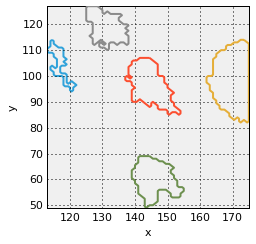

In [4]:
fig = hv.Overlay()
for i in range(len(rois)):
    fig*=hv.Curve(rois[i].coords[0][:,1::-1])
fig

Use FISSA with SIMA detected cells

FISSA needs either ImageJ ROIs or numpy arrays as inputs for the ROIs. 

SIMA outputs ROIs as numpy arrays, and can be directly read into FISSA.
A given roi is given as

```
rois[i].coords[0][:,:2].shape
```

SIMA expects a set of rois to be given as a list of lists

```
[[roiA1,roiA2,roiA3...]]
```
So some formatting will need to be done first.

In [5]:
numROI = len(rois)
rois_FISSA = [rois[i].coords[0][:,:2] for i in range(numROI)]

Which can then be put into FISSA and run

In [6]:
exp = fissa.Experiment(folder,[rois_FISSA])
exp.separate()

Doing region growing and data extraction....
Doing signal separation for trial....
NMF converged after 1186 iterations.
NMF converged after 1111 iterations.
NMF converged after 1076 iterations.
NMF converged after 1096 iterations.
NMF converged after 1143 iterations.


/home/swk/Code/rochefort-lab/fissa/fissa/ROI.py:145: UserWarning: Polygon initialized without z-coordinate. Assigning to zeroth plane (z = 0)
  'Assigning to zeroth plane (z = 0)')


And some plotting to show what it did

:Layout
   .HoloMap.I  :HoloMap   [Cell]
      :Overlay
         .Curve.I    :Curve   [x]   (y)
         .Curve.II   :Curve   [x]   (y)
         .Curve.III  :Curve   [x]   (y)
         .Curve.IV   :Curve   [x]   (y)
         .Curve.V    :Curve   [x]   (y)
         .Curve.VI   :Curve   [x]   (y)
         .Curve.VII  :Curve   [x]   (y)
         .Curve.VIII :Curve   [x]   (y)
         .Curve.IX   :Curve   [x]   (y)
         .Curve.X    :Curve   [x]   (y)
   .HoloMap.II :HoloMap   [Cell]
      :Overlay
         .Curve.I  :Curve   [x]   (y)
         .Curve.II :Curve   [x]   (y)
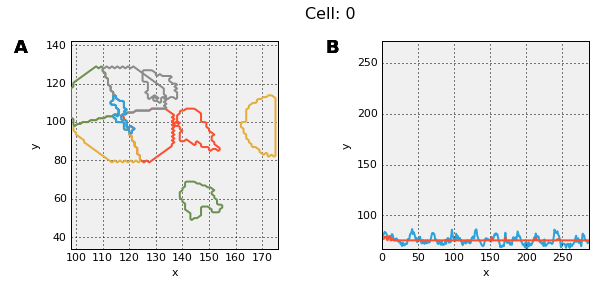
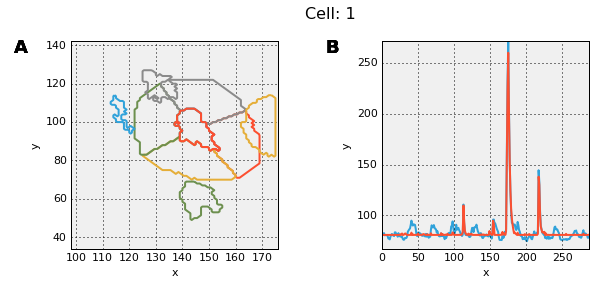
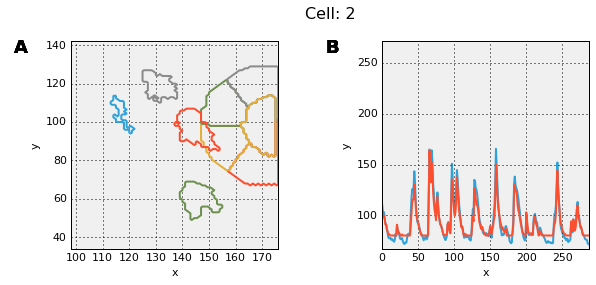
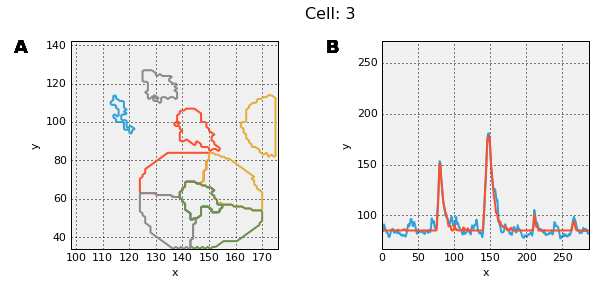
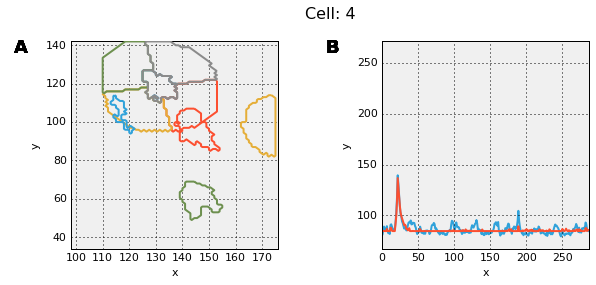

In [7]:
%%opts Curve {+axiswise}
# function for a single cell region plot
def plot_cell_regions(cell):
    out = hv.Overlay()
    numReg = len(exp.roi_polys[cell,0]) # Number of regions
    for i in range(numReg):
        out *= hv.Curve(exp.roi_polys[cell,0][i][0])
    return out

# get plots for all detected regions
region_plots = {i : plot_cell_regions(i) for i in range(exp.nCell)}

# get plots for raw extracts and neuropil removed
traces_plots = {i : hv.Curve(exp.raw[i,1][0,:])*hv.Curve(exp.matched[i,1][0,:]) for i in range(exp.nCell)}

hv.HoloMap(region_plots,kdims=['Cell'])*fig+hv.HoloMap(traces_plots,kdims=['Cell'])